# <center> RL and Advanced DL: Домашнее задание 2

Второе домашнее задание опять посвящено игре; его базовая часть, надеюсь, не слишком большая, но я добавил опциональную часть, которая, думаю, должна быть достаточно интересной для любого слушателя. Как обычно, в качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии. Любые комментарии, новые идеи и рассуждения на тему, как всегда, категорически приветствуются.
<img src='../resource/homework-2/img-1.png'>

In [1]:
import os
import random
from pathlib import Path
from collections import defaultdict, deque


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt

from utils import is_available, plot_percentage, get_action, get_action_from_model, state_to_layers
from tic_tac_toe import TicTacToe

##  Часть первая: крестики-нолики при помощи Q-обучения
В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны.
Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

In [2]:
class AgentQ:
    def __init__(self, alpha, gamma):
        self.alpha = alpha
        self.gamma = gamma
        self.s = None
        self.a = None
        
    def update(self, Q, state, action, reward):
        Q[self.s][self.a] += self.alpha * (reward + self.gamma * np.max(Q[state]) - Q[self.s][self.a])
        self.s = state
        self.a = action

In [3]:
class QLearnign:
    
    def __init__(self, env):
        self.env = env
        self.env.reset()
        self.cross_rewards = []
        self.noughts_rewards = []
        
        _, empty_spaces, _ = self.env.getState()
        self.A = np.arange(empty_spaces.shape[0])
        self.Q = defaultdict(lambda: np.zeros(len(self.A)))
    
    def fit(self, n=100000, alpha=0.05, epsilon=0.3, gamma=1, eval_perсent=0.01):
    
        for i in tqdm(range(n)):
            self.step(alpha=alpha, epsilon=epsilon, gamma=gamma)
            if i % (n*eval_perсent) == 0:
                self.cross_rewards.append(
                    self._eval(n=100, cross=False)[0]
                )
                self.noughts_rewards.append(
                    self._eval(n=100, cross=True)[1]
                )

        return self.cross_rewards, self.noughts_rewards
    
    def _eval(self, n=1000, cross=False):
        rewards_1 = []
        rewards_2 = []
        for _ in range(n):
            reward_1, reward_2 = self._play(
                print_board=False, 
                cross=cross, 
            )
            rewards_1.append(reward_1)
            rewards_2.append(reward_2)
        return np.mean(rewards_1), np.mean(rewards_2)

    def _play(self, print_board=False, cross=False):
        self.env.reset()
        s, empty_spaces, _ = env.getState()
        done = False
        result = [0, 0]
        player = 1
        while not done:

            if player == (1 and cross) or (player == -1 and not cross):
                action = random.choice(is_available(s, True))
            else:
                action = np.argmax(self.Q[s])
            action_tuple = env.action_from_int(action)
            (s, empty_spaces, _), reward, done, _ = self.env.step(action_tuple)
            if print_board:
                self.env.printBoard()
            player = player * -1

        if reward == 1:
            return (1, 0)
        elif reward == -1:
            return (0, 1)
        else:
            return (0, 0)

    def step(self, alpha=0.05, epsilon=0.1, gamma=1):
        self.env.reset()
        s, empty_spaces, turn = self.env.getState()    
        agents = (
            AgentQ(alpha=alpha, gamma=gamma), 
            AgentQ(alpha=alpha, gamma=gamma)
        )
        done = False
        agent_idx = 0

        while not done:
            self.Q[s][is_available(s, False)] = -float('inf')
            a = np.argmax(self.Q[s]) if random.random() < (1 - epsilon) else random.choice(is_available(s, True))
            agent = agents[agent_idx]
            agent.update(self.Q, s, a, 0)
            agent_idx = 1 - agent_idx 
            (s, empty_spaces, turn), r , done, _ = self.env.step(env.action_from_int(a))    

        if r == -10:
            agent.update(self.Q, s, a, r)
        else:
            agents[0].update(self.Q, s, a, r) 
            agents[1].update(self.Q, s, a, -r) 

In [4]:
env = TicTacToe(
                n_rows=3, 
                n_cols=3, 
                n_win=3
)

In [5]:
q_learning_3x3 = QLearnign(env)
n = 50000

In [6]:
cross_rewards, noughts_rewards = q_learning_3x3.fit(n=n, alpha=0.01, epsilon=0.7)

100%|██████████| 50000/50000 [00:24<00:00, 2043.02it/s]


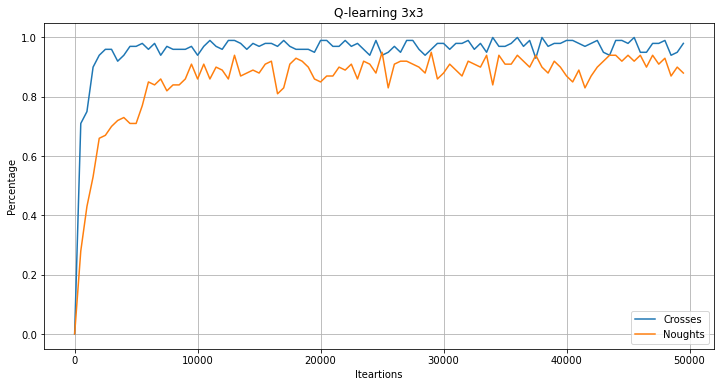

In [7]:
plot_percentage(np.arange(n, step=n*0.01), cross_rewards, noughts_rewards, 'Q-learning 3x3')

2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

In [8]:
env = TicTacToe(
                n_rows=4, 
                n_cols=4, 
                n_win=4
)

In [9]:
q_learning_4x4 = QLearnign(env)
n = 500000
cross_rewards, noughts_rewards = q_learning_4x4.fit(n=n, alpha=0.01, epsilon=0.7)

100%|██████████| 500000/500000 [08:02<00:00, 1035.91it/s]


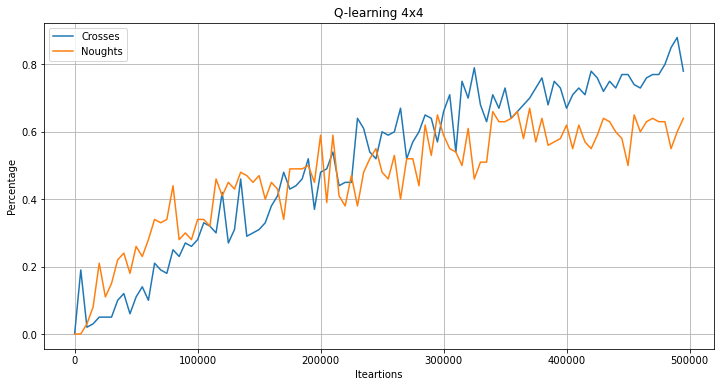

In [10]:
plot_percentage(np.arange(n, step=n*0.01), cross_rewards, noughts_rewards, 'Q-learning 4x4')

In [11]:
env = TicTacToe(
                n_rows=5, 
                n_cols=5, 
                n_win=5,
)

In [24]:
q_learning_5x5 = QLearnign(env)
n = 500000
cross_rewards, noughts_rewards = q_learning_5x5.fit(n=n, alpha=0.01, epsilon=0.9)

100%|██████████| 500000/500000 [16:12<00:00, 514.07it/s]


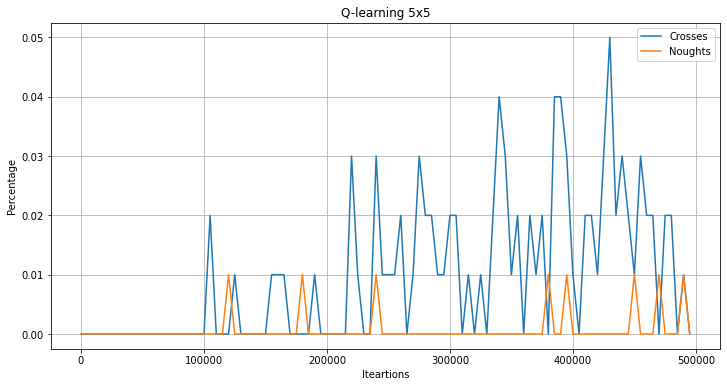

In [25]:
plot_percentage(np.arange(n, step=n*0.01), cross_rewards, noughts_rewards, 'Q-learning 5x5')

## Часть вторая: добавим нейронных сетей
Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).

3. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.

In [26]:
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size=64):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [27]:
class AgentDQN:
    def __init__(self, memory_capacity=10000):
        self.state = None
        self.action = None
        self.reward = None
        self.next_state = None
        self.memory = ReplayMemory(capacity=memory_capacity)
    
    def add_exp(self, next_state, action, reward):
        
        next_state = state_to_layers(next_state)
        if self.state is not None:
            self.memory.push((self.state, next_state, self.action, reward))
        self.state = next_state
        self.action = action
        
    def new_game(self):
        self.state = None
        self.action = None 

In [28]:
class DQNLearnign:
    
    def __init__(self, env, model, optimizer, criterion):
        self.env = env
        self.env.reset()
        self.cross_rewards = []
        self.noughts_rewards = []
        self.cross = AgentDQN()
        self.nought = AgentDQN()
        
        self.cross_rewards = []
        self.cross_model = model
        self.cross_optimizer = optimizer
        self.cross_scheduler = None

        self.nought_rewards = []
        self.nought_model = model
        self.nought_optimizer = optimizer
        self.nought_scheduler = None

        self.criterion = criterion

    def _play(self, model, cross=False):
        self.env.reset()
        s, empty_spaces, _ = env.getState()
        state = self.env.board
        done = False
        result = [0, 0]
        player = 1
        while not done:

            if player == (1 and cross) or (player == -1 and not cross):
                action = random.choice(is_available(s, True))
            else:
                action =  get_action_from_model(model, state)
            action_tuple = self.env.action_from_int(action)
            (s, empty_spaces, _), reward, done, _ = self.env.step(action_tuple)
            state = self.env.board
            player = player * -1

        if reward == 1:
            return (1, 0)
        elif reward == -1:
            return (0, 1)
        else:
            return (0, 0)

    def _train(self, model, optimizer, replay_memory, batch_size=128, gamma=1):
    
        if len(replay_memory) < batch_size:
            return

        states, next_states, actions, rewards = list(zip(*replay_memory.sample(batch_size)))

        batch_state = torch.FloatTensor(states)
        batch_next_state = torch.FloatTensor(next_states)
        batch_actions = torch.LongTensor(actions)
        batch_reward = torch.FloatTensor(rewards) / 11

        model.train()
        Q = model(batch_state).gather(1, batch_actions.view(-1, 1)).flatten()
        Qmax = model(batch_next_state).detach().max(dim=1)[0]
        Qnext = batch_reward + (gamma * Qmax)

        loss = criterion(Q, Qnext)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        return loss.item()

    def _eval(self, model, n=1000, cross=False):
        model.eval()
        rewards_1 = []
        rewards_2 = []
        for _ in range(n):
            reward_1, reward_2 = self._play(
                model, 
                cross=cross
            )
            rewards_1.append(reward_1)
            rewards_2.append(reward_2)
        win_1 = np.mean(rewards_1)
        win_2 = np.mean(rewards_2)
        draw = 1 - win_1 - win_2
        
        return win_1, win_2, draw

    def _start(self, epsilon):
        self.env.reset()
        self.cross_model.eval()
        self.nought_model.eval()
        game_hash, empty_spaces, turn = self.env.getState()
        state = self.env.board.copy()
        done = False
        self.cross.new_game()
        self.nought.new_game()
        players = (self.cross, self.nought)
        models = (self.cross_model, self.nought_model)
        step = 0

        while not done:
            player = players[step]
            model = models[step]
            action = get_action(model, state, game_hash, epsilon)
            player.add_exp(state, action, 0)
            step = 1 - step
            (game_hash, empty_spaces, turn), reward , done, _ = self.env.step(self.env.action_from_int(action))
            state = self.env.board.copy()

        if reward == -10:
            player.add_exp(state, action, reward)
        else:
            players[0].add_exp(state, action, reward)
            players[1].add_exp(state, action, -reward)
        
    def fit(self, n=10000, eps_init=0.5, batch_size=64, gamma=1, model_name='dqn', eval_perсent=0.01):

        best_result_cross = 0
        best_result_nought = 0
        
        Path('weights').mkdir(exist_ok=True)

        for i in tqdm(range(n)):
            eps_threshold = eps_init
            self._start(eps_threshold)

            cross_loss = self._train(
                self.cross_model, self.cross_optimizer, self.cross.memory, batch_size=batch_size, gamma=gamma
            )
            nought_loss = self._train(
                self.nought_model, self.nought_optimizer, self.nought.memory, batch_size=batch_size, gamma=gamma
            )

            if i % (n * eval_perсent) == 0:
                cross_val, _, _ = self._eval(self.cross_model, n=200, cross=False)
                _, nought_val, _ = self._eval(self.nought_model, n=200, cross=True)

                self.cross_rewards.append(cross_val)
                self.nought_rewards.append(nought_val)

                if self.cross_scheduler is not None:
                    self.cross_scheduler.step(np.mean(cross_loss))
                if self.nought_scheduler is not None:
                    self.nought_scheduler.step(np.mean(nought_loss))

                if best_result_cross < cross_val:
                    model_path = os.path.join('weights', f'best_{model_name}_p1.pth')
                    torch.save(self.cross_model.state_dict(), model_path)
                if best_result_nought < nought_val:
                    model_path = os.path.join('weights', f'best_{model_name}_p2.pth')
                    torch.save(self.nought_model.state_dict(), model_path)

        return self.cross_rewards, self.nought_rewards

In [29]:
class DQN_3x3(nn.Module):
    def __init__(self, hidden_size=512, kernel_size=(3, 3)):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=hidden_size, kernel_size=kernel_size)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 9)       
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = x.squeeze(-1).squeeze(-1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [30]:
class DQN_4x4(nn.Module):
    def __init__(self, conv1_channels=32, conv2_channels=256, kernel_size=(3, 3)):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=conv1_channels, kernel_size=kernel_size)
        self.conv2 = nn.Conv2d(in_channels=conv1_channels, out_channels=conv2_channels, kernel_size=(2, 2))
        self.fc1 = nn.Linear(conv2_channels, conv2_channels)
        self.fc2 = nn.Linear(conv2_channels, 16)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = x.squeeze(-1).squeeze(-1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        return x

In [31]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)

In [32]:
model = DQN_3x3(hidden_size=512)
optimizer = optim.Adam(model.parameters(), lr=1e-6, weight_decay=1e-9)
criterion = F.l1_loss

In [33]:
dqn_learning = DQNLearnign(env, model, optimizer, criterion)
n = 50000

In [34]:
cross_rewards, noughts_rewards = dqn_learning.fit(
    n=n, 
    eps_init=0.5,
    batch_size=64,
    gamma=0.9, 
    model_name='dqn_3x3',
    eval_perсent=0.01
)

100%|██████████| 50000/50000 [14:38<00:00, 56.88it/s]


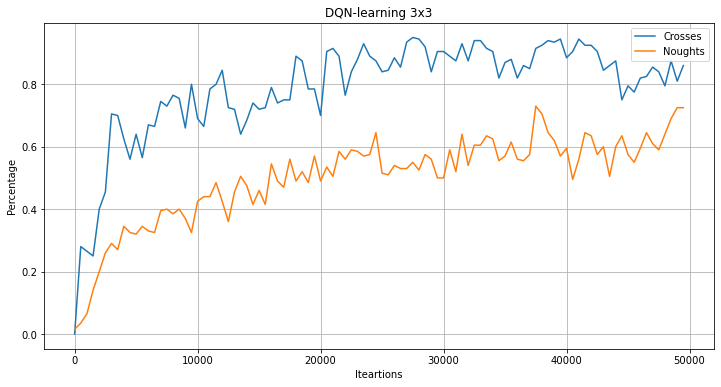

In [35]:
plot_percentage(np.arange(n, step=n*0.01), cross_rewards, noughts_rewards, 'DQN-learning 3x3')

In [36]:
env = TicTacToe(n_rows=4, n_cols=4, n_win=4)
model = DQN_4x4()
optimizer = optim.Adam(model.parameters(), lr=1e-6, weight_decay=1e-9)
criterion = F.l1_loss

In [37]:
dqn_learning = DQNLearnign(env, model, optimizer, criterion)
n = 50000 

In [38]:
cross_rewards, noughts_rewards = dqn_learning.fit(
    n=n, 
    eps_init=0.5,
    batch_size=64,
    gamma=0.9, 
    model_name='dqn_4x4',
    eval_perсent=0.01
)

100%|██████████| 50000/50000 [13:56<00:00, 59.78it/s]


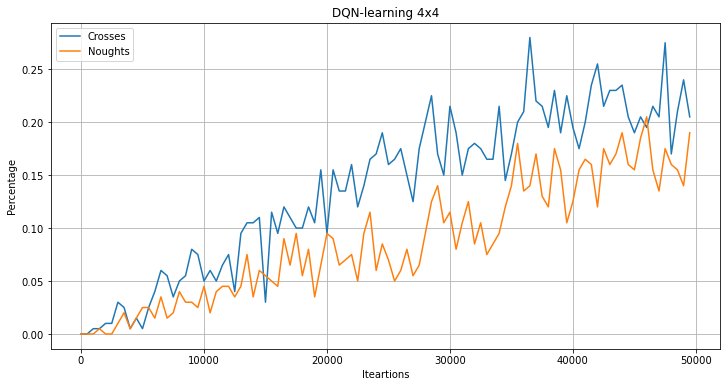

In [39]:
plot_percentage(np.arange(n, step=n*0.01), cross_rewards, noughts_rewards, 'DQN-learning 4x4')

4. Реализуйте Double DQN и/или Dueling DQN.


In [40]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)

In [41]:
class DuelingDQN_3x3(nn.Module):
    def __init__(self, hidden_size=256):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=hidden_size, kernel_size=(3, 3))
    
        self.V = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
        )
        
        self.A = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 9),
        )
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = x.squeeze(-1).squeeze(-1)
        A = self.A(x)
        V = self.V(x)
        Q = V + (A - A.mean(dim=1, keepdim=True).expand(x.size(0), 9))
        return Q

In [42]:
model = DuelingDQN_3x3()
optimizer = optim.Adam(model.parameters(), lr=1e-6, weight_decay=1e-9)
criterion = F.l1_loss

In [43]:
dqn_learning = DQNLearnign(env, model, optimizer, criterion)
n = 50000

In [44]:
cross_rewards, noughts_rewards = dqn_learning.fit(
    n=n, 
    eps_init=0.5,
    batch_size=64,
    gamma=0.9, 
    model_name='dueling-dqn_3x3',
    eval_perсent=0.01
)

100%|██████████| 50000/50000 [11:27<00:00, 72.69it/s]


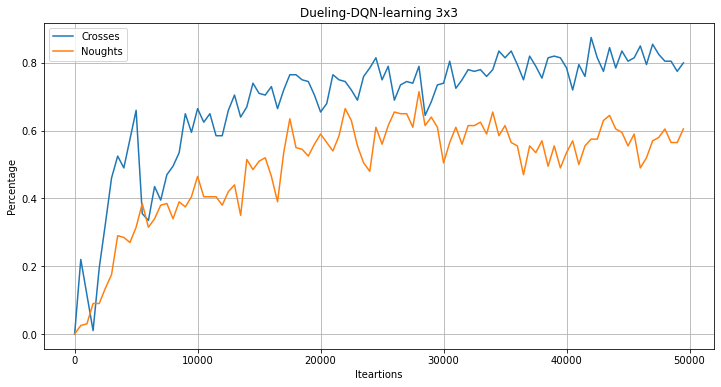

In [45]:
plot_percentage(np.arange(n, step=n*0.01), cross_rewards, noughts_rewards, 'Dueling-DQN-learning 3x3')

# Часть третья: расширим и углубим поиск

Крестики-нолики -- это, конечно, далеко не го, и обычный альфа-бета поиск с отсечением здесь наверняка может работать идеально вплоть до довольно больших досок. Однако мы всё-таки для этого учебного задания будем реализовывать более практически релевантный метод MCTS -- заодно фактически получится и упражнение на многоруких бандитов.

5. Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте).

6. Реализуйте MCTS-поиск с этими rollouts для крестиков-ноликов на досках разного размера, сравните полученные стратегии между собой и со стратегиями, обученными в первых двух частях.